## Getting the keys and installation

1. In order to get trial keys for Spark NLP for Healthcare
, fill the form at https://www.johnsnowlabs.com/spark-nlp-try-free/ and you will get your keys to your email in a few minutes.

2. On a new cluster or existing one

  - add the following to the `Advanced Options -> Spark` tab, in `Spark.Config` box:

    ```bash
    spark.local.dir /var
    spark.kryoserializer.buffer.max 1000M
    spark.serializer org.apache.spark.serializer.KryoSerializer
    ```
  - add the following to the `Advanced Options -> Spark` tab, in `Environment Variables` box:

    ```bash
    AWS_ACCESS_KEY_ID=xxx
    AWS_SECRET_ACCESS_KEY=yyy
    SPARK_NLP_LICENSE=zzz
    JSL_OCR_LICENSE=iii
    ```

3. Download the followings with AWS CLI to your local computer

     `$ aws s3 cp --region us-east-2 s3://pypi.johnsnowlabs.com/$jsl_secret/spark-nlp-jsl-$jsl_version.jar spark-nlp-jsl-$jsl_version.jar`

    `$ aws s3 cp --region us-east-2 s3://pypi.johnsnowlabs.com/$jsl_secret/spark-nlp-jsl/spark_nlp_jsl-$jsl_version-py3-none-any.whl spark_nlp_jsl-$jsl_version-py3-none-any.whl` 
    
    `$ aws s3 cp --region us-east-2 s3://pypi.johnsnowlabs.com/$jsl_ocr_secret/jars/spark-ocr-assembly-$ocr_version-spark30.jar spark-ocr-assembly-$ocr_version-spark30.jar`
    
    `$ aws s3 cp --region us-east-2 s3://pypi.johnsnowlabs.com/$jsl_ocr_secret/spark-ocr/spark_ocr-$ocr_version.spark30-py3-none-any.whl spark_ocr-$ocr_version.spark30-py3-none-any.whl`
    

4. In `Libraries` tab inside your cluster:

 - Install New -> PyPI -> `spark-nlp==$public_version` -> Install
 - Install New -> Maven -> Coordinates -> `com.johnsnowlabs.nlp:spark-nlp_2.12:$public_version` -> Install

 - add following jars for the Healthcare library that you downloaded above:
 
        - Install New -> Python Whl -> upload `spark_nlp_jsl-$jsl_version-py3-none-any.whl`

        - Install New -> Jar -> upload `spark-nlp-jsl-$jsl_version.jar`
        
        - Install New -> Python Whl -> upload `spark_ocr-$ocr_version.spark30-py3-none-any.whl`

        - Install New -> Jar -> upload `spark-ocr-assembly-$ocr_version-spark30.jar`

5. Now you can attach your notebook to the cluster and use Spark NLP!

For more information, see 

  https://nlp.johnsnowlabs.com/docs/en/install#databricks-support

  https://nlp.johnsnowlabs.com/docs/en/licensed_install#install-spark-nlp-for-healthcare-on-databricks

# Spark OCR in Healtcare

Spark OCR is a commercial extension of Spark NLP for optical character recognition from images, scanned PDF documents, Microsoft DOCX and DICOM files. 

In this notebook we will:
  - Parsing the Files through OCR.
  - Extract PHI entites from extracted texts.
  - Hide PHI entites and get an obfucated versions of pdf files.
  - Hide PHI entities on original image.
  - Extract text from some Dicom images.

In [0]:
import os
import json
import string
#import sys
#import base64
import numpy as np
import pandas as pd

import sparknlp
import sparknlp_jsl
from sparknlp.base import *
from sparknlp.util import *
from sparknlp.annotator import *
from sparknlp_jsl.base import *
from sparknlp_jsl.annotator import *
from sparknlp.pretrained import ResourceDownloader

import sparkocr
from sparkocr.transformers import *
from sparkocr.utils import *
from sparkocr.enums import *

from pyspark.sql import functions as F
from pyspark.ml import Pipeline, PipelineModel
from sparknlp.training import CoNLL

import matplotlib.pyplot as plt

pd.set_option('max_colwidth', 100)
pd.set_option('display.max_columns', 100)  
pd.set_option('display.expand_frame_repr', False)

spark.sql("set spark.sql.legacy.allowUntypedScalaUDF=true")

print('sparknlp.version : ',sparknlp.version())
print('sparknlp_jsl.version : ',sparknlp_jsl.version())
print('sparkocr : ',sparkocr.version())

spark

sparknlp.version : 3.0.3
sparknlp_jsl.version : 3.1.0rc1
sparkocr : 3.1.0
Out[1]:

SparkSession - hive 
 
 
 SparkContext 

 Spark UI 

 
 Version 
 v3.1.1 
 Master 
 local[8] 
 AppName 
 Databricks Shell

**Reading PDF files **
- We have some PDF files in delta tables and we are starting by reading them. We can use `spark.read` and load them by `load` function.

In [0]:
%sh
for i in {0..1}
do
  wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Healthcare/data/ocr/MT_0$i.pdf
done

In [0]:
pdfs = spark.read.format("binaryFile").load("file:/databricks/driver/MT_*")

print("Number of files in the folder : ", pdfs.count())

Number of files in the folder : 2

In [0]:
pdfs.show()

+--------------------+-------------------+------+--------------------+
 path| modificationTime|length| content|
+--------------------+-------------------+------+--------------------+
file:/databricks/...|2021-05-31 14:35:58|528022|[25 50 44 46 2D 3...|
file:/databricks/...|2021-05-31 14:35:58|165397|[25 50 44 46 2D 3...|
+--------------------+-------------------+------+--------------------+

## 1. Parsing the Files through OCR

- The pdf files can have more than one page. We will transform the document in to images per page. Than we can run OCR to get text. 
- We are using `PdfToImage()` to render PDF to images and `ImageToText()` to runs OCR for each images.

In [0]:
# Transform PDF document to images per page
pdf_to_image = PdfToImage()\
      .setInputCol("content")\
      .setOutputCol("image")

# Run OCR
ocr = ImageToText()\
      .setInputCol("image")\
      .setOutputCol("text")\
      .setConfidenceThreshold(65)\
      .setIgnoreResolution(False)

ocr_pipeline = PipelineModel(stages=[
    pdf_to_image,
    ocr
])

- Now, we can transform the `pdfs` with our pipeline.

In [0]:
ocr_result = ocr_pipeline.transform(pdfs)

- After transforming we get following columns :

  - path
  - modificationTime
  - length
  - image
  - total_pages
  - pagenum
  - documentnum
  - confidence
  - exception
  - text
  - positions

In [0]:
ocr_result.select('modificationTime', 'length', 'total_pages', 'pagenum', 'documentnum', 'confidence', 'exception').show(truncate=False)

+-------------------+------+-----------+-------+-----------+-----------------+---------+
modificationTime |length|total_pages|pagenum|documentnum|confidence |exception|
+-------------------+------+-----------+-------+-----------+-----------------+---------+
2021-05-31 14:35:58|528022|3 |0 |0 |93.96357955932618| |
2021-05-31 14:35:58|528022|3 |1 |0 |96.2877437046596 | |
2021-05-31 14:35:58|528022|3 |2 |0 |95.4769515991211 | |
2021-05-31 14:35:58|165397|1 |0 |0 |48.33505630493164| |
+-------------------+------+-----------+-------+-----------+-----------------+---------+

In [0]:
ocr_result.select('path', 'image', 'text', 'positions').show(truncate=30)

+------------------------------+------------------------------+------------------------------+------------------------------+
 path| image| text| positions|
+------------------------------+------------------------------+------------------------------+------------------------------+
file:/databricks/driver/MT_...|{file:/databricks/driver/MT...|Sample Type / Medical Speci...|[{[{Sample Type / Medical S...|
file:/databricks/driver/MT_...|{file:/databricks/driver/MT...|FAMILY HISTORY:
No family h...|[{[{FAMILY HISTORY:
No fami...|
file:/databricks/driver/MT_...|{file:/databricks/driver/MT...|from the pericardectomy in ...|[{[{from the pericardectomy...|
file:/databricks/driver/MT_...|{file:/databricks/driver/MT...|by Mr. ‘ on 3 7/10/68
C Sam...|[{[{by Mr. ‘ on 3 7/10/68
C...|
+------------------------------+------------------------------+------------------------------+------------------------------+

- Now, we have our pdf files in text format and as image. 

- In `sparkocr`library, we have `display_image` function to display any image. Images are stored in the `image` column of `results`.  Let's see the image and the text.

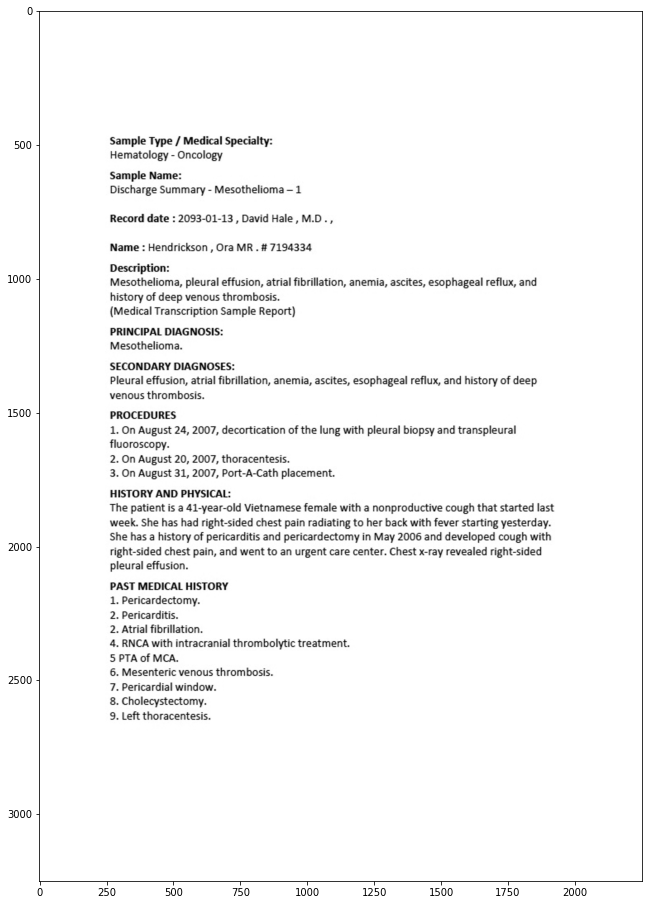

In [0]:
import matplotlib.pyplot as plt

img = ocr_result.collect()[0].image
img_pil = to_pil_image(img, img.mode)

plt.figure(figsize=(24,16))
plt.imshow(img_pil, cmap='gray')
plt.show()

- Let's see extracted text which is stored in `'text'` column as a list. Each line is is an item in this list, so we can join them and see the whole page.

In [0]:
print("\n".join([row.text for row in ocr_result.select("text").collect()[0:1]]))

Sample Type / Medical Specialty:
Hematology - Oncology

Sample Name:
Discharge Summary - Mesothelioma — 1

Record date : 2093-01-13 , David Hale, M.D.,

Name: Hendrickson , Ora MR. # 7194334

Description:

Mesothelioma, pleural effusion, atrial fibrillation, anemia, ascites, esophageal reflux, and
history of deep venous thrombosis.

(Medical Transcription Sample Report)

PRINCIPAL DIAGNOSIS:
Mesothelioma.

SECONDARY DIAGNOSES:
Pleural effusion, atrial fibrillation, anemia, ascites, esophageal reflux, and history of deep
venous thrombosis.

PROCEDURES

1. On August 24, 2007, decortication of the lung with pleural biopsy and transpleural
fluoroscopy.

2. On August 20, 2007, thoracentesis.

3. On August 31, 2007, Port-A-Cath placement.

HISTORY AND PHYSICAL:

The patient is a 41-year-old Vietnamese female with a nonproductive cough that started last
week. She has had right-sided chest pain radiating to her back with fever starting yesterday.
She has a history of pericarditis and pericardectomy in May 2006 and developed cough with
right-sided chest pain, and went to an urgent care center. Chest x-ray revealed right-sided
pleural effusion.

PAST MEDICAL HISTORY

1. Pericardectomy.

2. Pericarditis.

2. Atrial fibrillation.

4. RNCA with intracranial thrombolytic treatment.
5 PTA of MCA.

6. Mesenteric venous thrombosis.

7. Pericardial window.

8. Cholecystectomy.

9. Left thoracentesis.

### 1.1. Skew Correction

In some images, there may be some skewness and this reduces acuracy of the extracted text. Spark OCR has `ImageSkewCorrector` which detects skew of the image and rotates it.

In [0]:
# Image skew corrector 
pdf_to_image = PdfToImage()\
      .setInputCol("content")\
      .setOutputCol("image")

skew_corrector = ImageSkewCorrector()\
      .setInputCol("image")\
      .setOutputCol("corrected_image")\
      .setAutomaticSkewCorrection(True)

ocr = ImageToText()\
      .setInputCol("corrected_image")\
      .setOutputCol("text")\
      .setConfidenceThreshold(65)\
      .setIgnoreResolution(False)

ocr_skew_corrected = PipelineModel(stages=[
    pdf_to_image,
    skew_corrector,
    ocr
])

In [0]:
ocr_skew_corrected_result = ocr_skew_corrected.transform(pdfs).cache()

Let's see the results after the skew correction.

In [0]:
print("Original Images")
ocr_result.filter(ocr_result.path=="file:/databricks/driver/MT_01.pdf").select('path', 'confidence').show(truncate=False)

print("Skew Corrected Images")
ocr_skew_corrected_result.filter(ocr_skew_corrected_result.path=="file:/databricks/driver/MT_01.pdf").select('path', 'confidence').show(truncate=False)

Original Images
+---------------------------------+-----------------+
path |confidence |
+---------------------------------+-----------------+
file:/databricks/driver/MT_01.pdf|48.33505630493164|
+---------------------------------+-----------------+

Skew Corrected Images
+---------------------------------+-----------------+
path |confidence |
+---------------------------------+-----------------+
file:/databricks/driver/MT_01.pdf|66.58824359669404|
+---------------------------------+-----------------+

After skew correction, confidence is increased from %48.3 to % %66.5. Let's display the corrected image and the original image side by side.

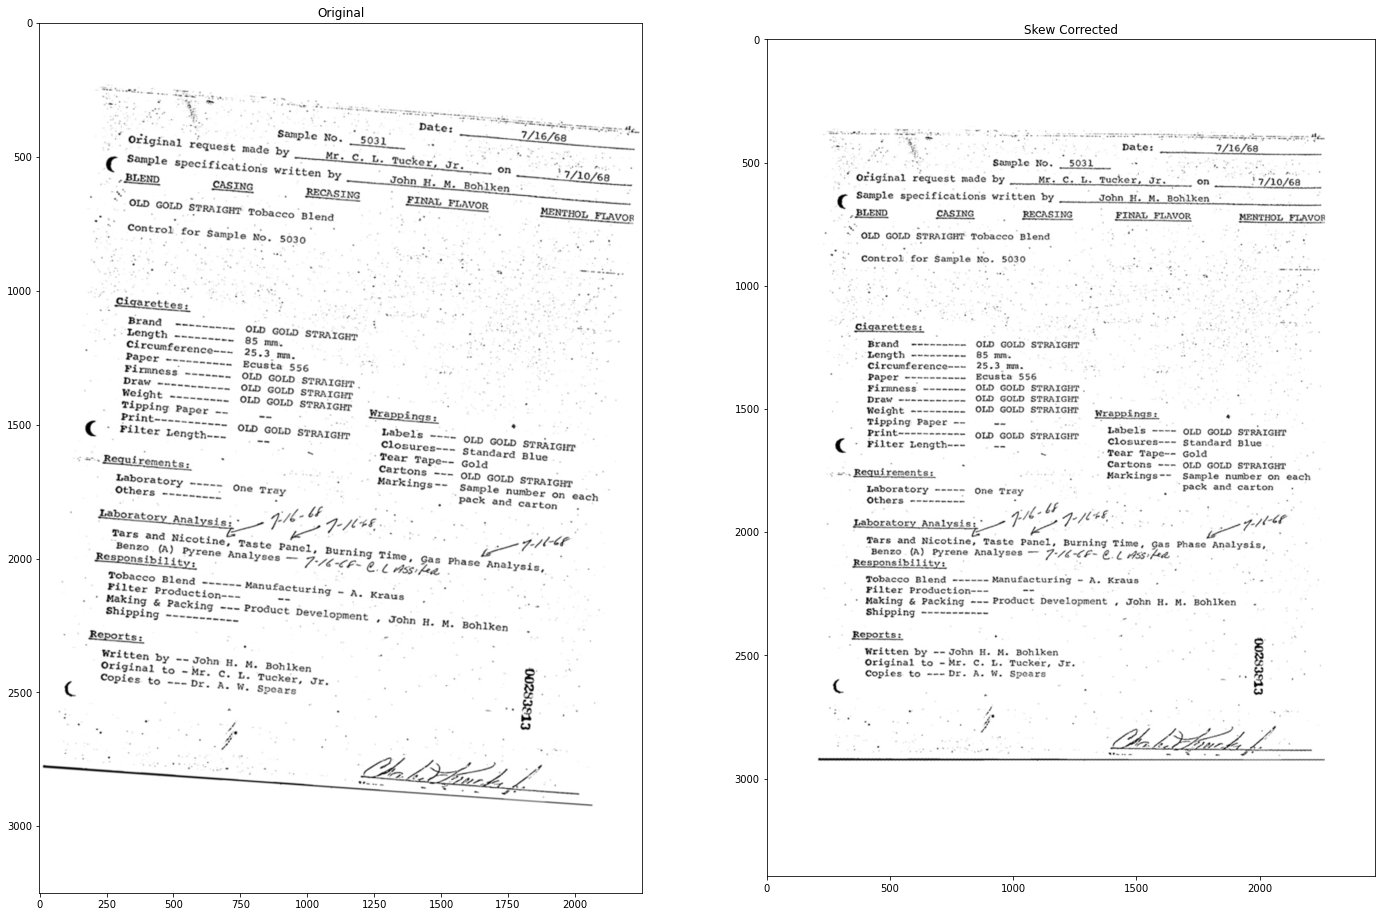

In [0]:
img_orig = ocr_skew_corrected_result.select("image").collect()[3].image
img_corrected = ocr_skew_corrected_result.select("corrected_image").collect()[3].corrected_image

img_pil_orig = to_pil_image(img_orig, img_orig.mode)
img_pil_corrected = to_pil_image(img_corrected, img_corrected.mode)

plt.figure(figsize=(24,16))
plt.subplot(1, 2, 1)
plt.imshow(img_pil_orig, cmap='gray')
plt.title('Original')
plt.subplot(1, 2, 2)
plt.imshow(img_pil_corrected, cmap='gray')
plt.title("Skew Corrected")
plt.show()

### 1.2. Image Processing

* After reading pdf files, we can process on images to increase the confidency.

* By **`ImageAdaptiveThresholding`**, we can compute a threshold mask image based on local pixel neighborhood and apply it to image. 

* Another method which we can add to pipeline is applying morphological operations. We can use **`ImageMorphologyOperation`** which support:
  - Erosion
  - Dilation
  - Opening
  - Closing   

* To remove remove background objects **`ImageRemoveObjects`** can be used.

* We will add **`ImageLayoutAnalyzer`** to pipeline, to analyze the image and determine the regions of text.

In [0]:
from sparkocr.enums import *

# Read binary as image
pdf_to_image = PdfToImage()\
  .setInputCol("content")\
  .setOutputCol("image")\
  .setResolution(400)

# Correcting the skewness
skew_corrector = ImageSkewCorrector()\
      .setInputCol("image")\
      .setOutputCol("skew_corrected_image")\
      .setAutomaticSkewCorrection(True)

# Binarize using adaptive tresholding
binarizer = ImageAdaptiveThresholding()\
  .setInputCol("skew_corrected_image")\
  .setOutputCol("binarized_image")\
  .setBlockSize(91)\
  .setOffset(50)

# Apply morphology opening
opening = ImageMorphologyOperation()\
  .setKernelShape(KernelShape.SQUARE)\
  .setOperation(MorphologyOperationType.OPENING)\
  .setKernelSize(3)\
  .setInputCol("binarized_image")\
  .setOutputCol("opening_image")

# Remove small objects
remove_objects = ImageRemoveObjects()\
  .setInputCol("opening_image")\
  .setOutputCol("corrected_image")\
  .setMinSizeObject(130)

# Run OCR for corrected image
ocr_corrected = ImageToText()\
  .setInputCol("corrected_image")\
  .setOutputCol("corrected_text")\
  .setPageIteratorLevel(PageIteratorLevel.SYMBOL) \
  .setPageSegMode(PageSegmentationMode.SPARSE_TEXT) \
  .setConfidenceThreshold(70)

# OCR pipeline
image_pipeline = PipelineModel(stages=[
    pdf_to_image,
    skew_corrector,
    binarizer,
    opening,
    remove_objects,
    ocr_corrected
])

In [0]:
result_processed = image_pipeline.transform(pdfs).cache()

Let's see the original image and corrected image.

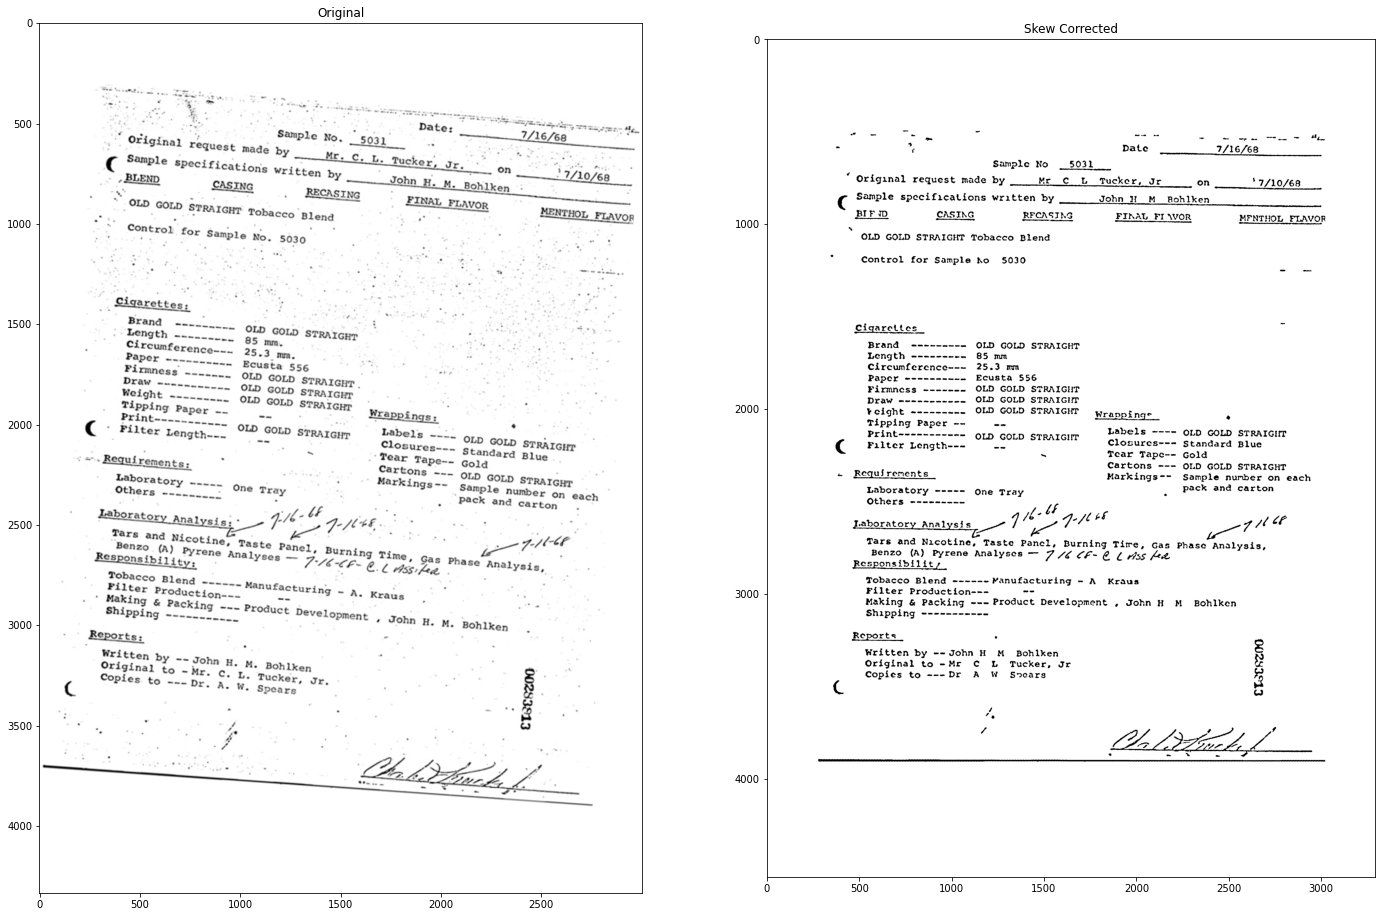

In [0]:
img_orig = result_processed.select("image").collect()[3].image
img_corrected = result_processed.select("corrected_image").collect()[3].corrected_image

img_pil_orig = to_pil_image(img_orig, img_orig.mode)
img_pil_corrected = to_pil_image(img_corrected, img_corrected.mode)

plt.figure(figsize=(24,16))
plt.subplot(1, 2, 1)
plt.imshow(img_pil_orig, cmap='gray')
plt.title('Original')
plt.subplot(1, 2, 2)
plt.imshow(img_pil_corrected, cmap='gray')
plt.title("Skew Corrected")
plt.show()

After processing, we have cleaner image. And confidence is increased to %97

In [0]:
print("Original Images")
ocr_result.filter(ocr_result.path=="file:/databricks/driver/MT_01.pdf").select('path', 'confidence').show(truncate=False)

print("Skew Corrected Images")
ocr_skew_corrected_result.filter(ocr_skew_corrected_result.path=="file:/databricks/driver/MT_01.pdf").select('path', 'confidence').show(truncate=False)

print("Corrected Images")
result_processed.filter(result_processed.path=="file:/databricks/driver/MT_01.pdf").select('path', 'confidence').show(truncate=False)

Original Images
+---------------------------------+-----------------+
path |confidence |
+---------------------------------+-----------------+
file:/databricks/driver/MT_01.pdf|48.33505630493164|
+---------------------------------+-----------------+

Skew Corrected Images
+---------------------------------+-----------------+
path |confidence |
+---------------------------------+-----------------+
file:/databricks/driver/MT_01.pdf|66.58824359669404|
+---------------------------------+-----------------+

Corrected Images
+---------------------------------+-----------------+
path |confidence |
+---------------------------------+-----------------+
file:/databricks/driver/MT_01.pdf|97.74610498837964|
+---------------------------------+-----------------+

## 2. Extracting the PHI Entites

Now Let's create a clinical NER pipeline and see which entities we have. We will use `sentence_detector_dl_healthcare` to detect sentences and get entities by using [`jsl_ner_wip_clinical`](https://nlp.johnsnowlabs.com/2021/03/31/jsl_ner_wip_clinical_en.html) in `MedicalNerModel`.

In [0]:
documentAssembler = DocumentAssembler()\
  .setInputCol("text")\
  .setOutputCol("document")

sentenceDetector = SentenceDetectorDLModel.pretrained("sentence_detector_dl_healthcare","en","clinical/models")\
  .setInputCols(["document"]) \
  .setOutputCol("sentence")

tokenizer = Tokenizer()\
  .setInputCols(["sentence"])\
  .setOutputCol("token")\

word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
  .setInputCols(["sentence", "token"])\
  .setOutputCol("embeddings")

ner = MedicalNerModel.pretrained("jsl_ner_wip_clinical", "en", "clinical/models") \
  .setInputCols(["sentence", "token", "embeddings"]) \
  .setOutputCol("ner")

ner_converter = NerConverter() \
  .setInputCols(["sentence", "token", "ner"]) \
  .setOutputCol("ner_chunk")

sentence_detector_dl_healthcare download started this may take some time.
Approximate size to download 363.9 KB
[ | ][ / ][ — ][ \ ][OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][OK!]
jsl_ner_wip_clinical download started this may take some time.
Approximate size to download 14.5 MB
[ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][OK!]

In [0]:
ner_pipeline = Pipeline(
    stages = [
        documentAssembler,
        sentenceDetector,
        tokenizer,
        word_embeddings,
        ner,
        ner_converter])

empty_data = spark.createDataFrame([['']]).toDF("text")
ner_model = ner_pipeline.fit(empty_data)

In [0]:
ner_results = ner_model.transform(ocr_result)

Now we will visualize a sample text with `NerVisualizer`.

`NerVisualizer` woks with Lightpipeline, so we will create a `light_model` with our ner_model.

In [0]:
sample_text = ocr_result.select("text").collect()[1].text

In [0]:
print(sample_text)

FAMILY HISTORY:
No family history of coronary artery disease, CVA, diabetes, CHF or MI. The patient has one
family member, a sister, with history of cancer.

SOCIAL HISTORY:
She is married. Employed with the US Post Office. She is a mother of three. Denies tobacco,
alcohol or illicit drug use.

MEDICATIONS
1. Coumadin 1 mg daily. Last INR was on Tuesday, August 14, 2007, and her INR was 2.3.
2. Amiodarone 100 mg p.o. daily.

REVIEW OF SYSTEMS:
Complete review of systems negative except as in pulmonary as noted above. The patient also
reports occasional numbness and tingling of her left arm.

PHYSICAL EXAMINATION

VITAL SIGNS: Blood pressure 123/95, heart rate 83, respirations 20, temperature 97, and
oxygen saturation 97%.

GENERAL: Positive nonproductive cough and pain with coughing.

HEENT: Pupils are equal and reactive to light and accommodation. Tympanic membranes are
clear.

NECK: Supple. No lymphadenopathy. No masses.

RESPIRATORY: Pleural friction rub is noted.

GI: Soft, nondistended, and nontender. Positive bowel sounds. No organomegaly.
EXTREMITIES: No edema, no clubbing, no cyanosis, no tenderness. Full range of motion. Normal
pulses in all extremities.

SKIN: No breakdown or lesions. No ulcers.

NEUROLOGIC: Grossly intact. No focal deficits. Awake, alert, and oriented to person, place, and
time.

LABORATORY DATA:
Labs are pending.

HOSPITAL COURSE:

The patient was admitted for a right-sided pleural effusion for thoracentesis on Monday by Dr.
X. Her Coumadin was placed on hold. A repeat echocardiogram was checked. She was started
on prophylaxis for DVT with Lovenox 40 mg subcutaneously. Her history dated back to March
2005 when she first sought medical attention for evidence of pericarditis, which was treated
with pericardial window in an outside hospital, at that time she was also found to have
mesenteric pain and thrombosis, is now anticoagulated. Her pericardial fluid was accumulated
and she was seen by Dr. Y. At that time, she was recommended for pericardectomy, which was
performed by Dr. Z. Review of her CT scan from March 2006 prior to her pericardectomy,
already shows bilateral plural effusions. The patient improved clinically after the
pericardectomy with resolution of her symptoms. Recently, she was readmitted to the hospital
with chest pain and found to have bilateral pleural effusion, the right greater than the left. CT
of the chest also revealed a large mediastinal lymph node. We reviewed the pathology obtained

In [0]:
light_model =  LightPipeline(ner_model)
 
ann_text = light_model.fullAnnotate(sample_text)[0]

`fullAnnotate` method returns the results as a dictionary. But the dictionary stored in a list. So we can reach to the dict by adding `[0]` to the end of the annotated text.

We can get some columns and transform them to a Pandas dataframe.

In [0]:
chunks = []
entities = []
sentence= []
begin = []
end = []

for n in ann_text['ner_chunk']:
        
    begin.append(n.begin)
    end.append(n.end)
    chunks.append(n.result)
    entities.append(n.metadata['entity']) 
    sentence.append(n.metadata['sentence'])
    
    
import pandas as pd

df = pd.DataFrame({'chunks':chunks, 'begin': begin, 'end':end, 
                   'sentence_id':sentence, 'entities':entities})

df.head(20)

Out[25]:

,chunks,begin,end,sentence_id,entities
0,FAMILY HISTORY:,0,14,0,Family_History_Header
1,coronary artery disease,37,59,0,Heart_Disease
2,CVA,62,64,0,Cerebrovascular_Disease
3,diabetes,67,74,0,Diabetes
4,CHF,77,79,0,Heart_Disease
5,MI,84,85,0,Heart_Disease
6,sister,125,130,1,Gender
7,cancer,149,154,1,Oncological
8,SOCIAL HISTORY:,158,172,2,Social_History_Header
9,She,174,176,2,Gender


We can visualise the annotated text by `display` method of `NerVisualizer()`

In [0]:
from sparknlp_display import NerVisualizer
 
visualiser = NerVisualizer()

ner_vis = visualiser.display(ann_text, label_col='ner_chunk',return_html=True)
 
displayHTML(ner_vis)

FAMILY HISTORY: Family_History_Header No family history of coronary artery disease Heart_Disease , CVA Cerebrovascular_Disease , diabetes Diabetes , CHF Heart_Disease or MI Heart_Disease . The patient has one family member, a sister Gender , with history of cancer Oncological . SOCIAL HISTORY: Social_History_Header She Gender is married Relationship_Status . Employed with the US Post Office Clinical_Dept . She Gender is a mother Gender of three. Denies tobacco Smoking , alcohol Alcohol or illicit drug Substance use. MEDICATIONS Section_Header 1. Coumadin Drug_BrandName 1 mg Strength daily Frequency . Last INR Test was on Tuesday RelativeDate , August 14, 2007 Date , and her Gender INR Test was 2.3 Test_Result . 2 Dosage . Amiodarone Drug_Ingredient 100 mg Strength p.o Route . daily Frequency . REVIEW OF SYSTEMS: Section_Header Complete review of systems negative except as in pulmonary Internal_organ_or_component as noted above. The patient also reports occasional Modifier numbness Symptom and tingling of her left arm Symptom . PHYSICAL EXAMINATION Vital_Signs_Header VITAL SIGNS: Vital_Signs_Header Blood pressure 123/95 Blood_Pressure , heart rate 83 Pulse , respirations 20 Respiration , temperature 97 Temperature , and oxygen saturation 97% O2_Saturation . GENERAL: Vital_Signs_Header Positive nonproductive Modifier cough Symptom and pain Symptom with coughing Symptom . HEENT: Pupils External_body_part_or_region are equal and reactive to light and accommodation. Tympanic membranes Internal_organ_or_component are clear. NECK: Supple. No lymphadenopathy Symptom . No masses Symptom . RESPIRATORY: Pleural friction rub Symptom is noted. GI: Soft, nondistended, and nontender Symptom . Positive bowel Internal_organ_or_component sounds. No organomegaly Symptom . EXTREMITIES: No edema Symptom , no clubbing Symptom , no cyanosis VS_Finding , no tenderness Symptom . Full range of motion. Normal pulses in all extremities External_body_part_or_region . SKIN: No breakdown Symptom or lesions Symptom . No ulcers Symptom . NEUROLOGIC: Grossly intact. No focal deficits Symptom . Awake, alert, and oriented to person, place, and time. LABORATORY DATA: Section_Header Labs are pending. HOSPITAL COURSE: Section_Header The patient was admitted Admission_Discharge for a right-sided Direction pleural effusion Disease_Syndrome_Disorder for thoracentesis Procedure on Monday RelativeDate by Dr. X. Her Gender Coumadin Drug_BrandName was placed on hold. A repeat echocardiogram Test was checked. She Gender was started on prophylaxis for DVT Disease_Syndrome_Disorder with Lovenox Drug_BrandName 40 mg Strength subcutaneously Route . Her Gender history dated back to March 2005 Date when she Gender first sought medical attention for evidence of pericarditis Disease_Syndrome_Disorder , which was treated with pericardial window Procedure in an outside hospital Clinical_Dept , at that time she Gender was also found to have mesenteric pain Symptom and thrombosis Disease_Syndrome_Disorder , is now anticoagulated Drug_Ingredient . Her Gender pericardial fluid Internal_organ_or_component was accumulated and she Gender was seen by Dr. Y. At that time, she Gender was recommended for pericardectomy Procedure , which was performed by Dr. Z. Review of her Gender CT scan Test from March 2006 Date prior to her Gender pericardectomy Procedure , already shows bilateral Direction plural effusions Disease_Syndrome_Disorder . The patient improved clinically after the pericardectomy Procedure with resolution of her Gender symptoms. Recently, she Gender was readmitted Admission_Discharge to the hospital Clinical_Dept with chest pain Symptom and found to have bilateral Direction pleural effusion Disease_Syndrome_Disorder , the right Direction greater than the left Direction . CT of the chest Test also revealed a large mediastinal lymph node Symptom . We reviewed the pathology Clinical_Dept obtained

## 3. Hiding the PHI Entities

In our documents we have some fields which we want to hide. To do it, we will use deidentification model. It identifies instances of protected health information in text documents, and it can either obfuscate them (e.g., replacing names with different, fake names) or mask them.

In [0]:
def deidentification_nlp_pipeline(input_column, prefix = ""):
    document_assembler = DocumentAssembler() \
        .setInputCol(input_column) \
        .setOutputCol(prefix + "document")

    # Sentence Detector annotator, processes various sentences per line
    sentence_detector = SentenceDetector() \
        .setInputCols([prefix + "document"]) \
        .setOutputCol(prefix + "sentence")

    tokenizer = Tokenizer() \
        .setInputCols([prefix + "sentence"]) \
        .setOutputCol(prefix + "token")

    # Clinical word embeddings
    word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models") \
        .setInputCols([prefix + "sentence", prefix + "token"]) \
        .setOutputCol(prefix + "embeddings")
    # NER model trained on i2b2 (sampled from MIMIC) dataset
    clinical_ner = MedicalNerModel.pretrained("ner_deid_large", "en", "clinical/models") \
        .setInputCols([prefix + "sentence", prefix + "token", prefix + "embeddings"]) \
        .setOutputCol(prefix + "ner")

    custom_ner_converter = NerConverterInternal() \
        .setInputCols([prefix + "sentence", prefix + "token", prefix + "ner"]) \
        .setOutputCol(prefix + "ner_chunk")

    nlp_pipeline = Pipeline(stages=[
            document_assembler,
            sentence_detector,
            tokenizer,
            word_embeddings,
            clinical_ner,
            custom_ner_converter
        ])
    empty_data = spark.createDataFrame([[""]]).toDF(input_column)
    nlp_model = nlp_pipeline.fit(empty_data)
    return nlp_model

In [0]:
obfuscation = DeIdentification()\
      .setInputCols(["sentence", "token", "ner_chunk"]) \
      .setOutputCol("deidentified") \
      .setMode("obfuscate")\
      .setObfuscateRefSource("faker")\
      .setObfuscateDate(True)

obfuscation_pipeline = Pipeline(stages=[
        image_pipeline,                        
        deidentification_nlp_pipeline(input_column="corrected_text"),
        obfuscation

    ])

embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[ | ][OK!]
ner_deid_large download started this may take some time.
Approximate size to download 14.1 MB
[ | ][ / ][ — ][OK!]

In [0]:
from pyspark.sql.types import BinaryType

empty_data = spark.createDataFrame([['']]).toDF("path")
empty_data = empty_data.withColumn('content', empty_data.path.cast(BinaryType()))

#empty_data = spark.createDataFrame([[""]]).toDF('content')
obfuscation_model = obfuscation_pipeline.fit(empty_data)

In [0]:
obfuscation_result = obfuscation_model.transform(pdfs).cache()

In [0]:
result_df = obfuscation_result.select(F.explode(F.arrays_zip('token.result', 'ner.result')).alias("cols")) \
                              .select(F.expr("cols['0']").alias("token"),
                                      F.expr("cols['1']").alias("ner_label"))

Let's count the number of entities we want to deidentificate and then see them.

In [0]:
result_df.select("token", "ner_label").groupBy('ner_label').count().orderBy('count', ascending=False).show(truncate=False)

+----------+-----+
ner_label |count|
+----------+-----+
O |1071 |
I-DATE |19 |
B-DATE |14 |
I-NAME |13 |
B-NAME |7 |
I-LOCATION|2 |
B-LOCATION|1 |
B-AGE |1 |
+----------+-----+

In [0]:
obfuscation_result.select(F.explode(F.arrays_zip('ner_chunk.result', 'ner_chunk.metadata')).alias("cols")) \
                  .select(F.expr("cols['0']").alias("chunk"),
                          F.expr("cols['1']['entity']").alias("ner_label")).show(truncate=False)

+-----------------------+---------+
chunk |ner_label|
+-----------------------+---------+
2093 |DATE |
Hendrickson |NAME |
August 24 2007 |DATE |
August 20 2007 |DATE |
August 31 2007 |DATE |
41 |AGE |
May 2006 |DATE |
US Post Office |LOCATION |
Tuesday August 14, 2007|DATE |
Monday |DATE |
March
2005 |DATE |
March 2006 |DATE |
March 2006 |DATE |
September 1 2007 |DATE |
September
1, 2007 |DATE |
XYZ |NAME |
Tuesday |DATE |
7/16/68 |DATE |
Cc L Tucker, Jr |NAME |
John H
M Rohlken |NAME |
+-----------------------+---------+
only showing top 20 rows

In deidentified column, entities like date and name are replaced by fake identities. Let's see some of them.

In [0]:
obfusated_text_df = obfuscation_result.select('path', F.explode(F.arrays_zip('sentence.result', 'deidentified.result')).alias("cols")) \
                                      .select('path', F.expr("cols['0']").alias("sentence"), F.expr("cols['1']").alias("deidentified")).toPandas()

In [0]:
obfusated_text_df.iloc[[4]]

Out[35]:

,path,sentence,deidentified
4,file:/databricks/driver/MT_00.pdf,from the pericardectomy in March 2006 which was diagnostic of mesothelioma At this time\nchest t...,from the pericardectomy in 06-10-1983 which was diagnostic of mesothelioma At this time\nchest t...


In [0]:
print("*" * 30)
print("Original Text")
print("*" * 30)
print(obfusated_text_df.iloc[4]['sentence'][:100])

print("*" * 30)
print("Obfusated Text")
print("*" * 30)

print(obfusated_text_df.iloc[4]['deidentified'][:100])

******************************
Original Text
******************************
from the pericardectomy in March 2006 which was diagnostic of mesothelioma At this time
chest tube p
******************************
Obfusated Text
******************************
from the pericardectomy in 06-10-1983 which was diagnostic of mesothelioma At this time
chest tube p

## 4. Getting Obfuscated Version of Each File
Now we have obfuscated version of each file in dataframe. Each page is in diiferent page. Let's merge and save the files as txt.

In [0]:
obfusated_text_df['Deidintified_Test'] = obfusated_text_df.groupby('path').deidentified.transform((lambda x: ''.join(x)))
obfuscated_versions = obfusated_text_df[['path', 'Deidintified_Test']].drop_duplicates()

obfuscated_versions

Out[37]:

,path,Deidintified_Test
0,file:/databricks/driver/MT_00.pdf,Sample Type / Medical Specialty\nHematology Oncology\nSample Name\nDischarge Summary Mesotheliom...
5,file:/databricks/driver/MT_01.pdf,-\n—\n—p me\n—\n—\n~~\nay\nDate\nEe AS\n03-27-1987\nSample No\n5031\n° Original request made by\...


In [0]:
#Writing txt versions
for index, row in obfuscated_versions.iterrows():
  with open(row.path.split("/")[-1].replace('pdf', 'txt'), 'w') as txt:
    txt.write(row.Deidintified_Test)

We have written the txt files with the same name with .txt extension. Let's read and see the a file.

In [0]:
from os import listdir

filenames = listdir(".")
text_files = [ filename for filename in filenames if filename.endswith('.txt') ]
text_files

Out[39]: ['MT_00.txt', 'MT_01.txt']

In [0]:
with open(text_files[0], 'r') as txt:
  print(txt.read())

Sample Type / Medical Specialty
Hematology Oncology
Sample Name
Discharge Summary Mesothelioma —1
Record date 04-07-1973 01 13,DavidHale,MD ,
Name Quenten Lund, OraMR #7194334
Description
Mesothelioma pleural effusion atrial fibrillation, anemia ascites, esophageal reflux and
history of deep venous thrombosis
(Medical Transcription Sample Report)
PRINCIPAL DIAGNOSIS
Mesothelioma
SECONDARY DIAGNOSES
Pleural effusion atrial fibrillation anemia ascites esophageal reflux and history of deep
venous thrombosis
PROCEDURES
1 On 08-05-1986, decortication of the lung with pleural biopsy and transpleural
fluoroscopy
2 On 11-11-1975, thoracentesis
3 On 03-25-1988, Port A-Cath placement
HISTORY AND PHYSICAL
The patient is a 20 year-old Vietnamese female with a nonproductive cough that started last
week.She has had right sided chest pain radiating to her back with fever starting yesterday
She has a history of pericarditis and pericardectomy in 09-04-1986 and developed cough with
right sided chest pain and went to an urgent care center Chest x ray revealed right sided
pleural effusion
PAST MEDICAL HISTORY
1 Pericardectomy
2 Pericarditis
2 Atrial fibrillation
4 RNCA with intracranial thrombolytic treatment
5 PTA of MCA
6 Mesenteric venous thrombosis
7 Pericardial window
8 Cholecystectomy
9 Left thoracentesisFAMILY HISTORY
No family history of coronary artery disease CVA diabetes CHF or MI!The patient has one
family member a sister with history of cancer
SOCIAL HISTORY
She is married Employed with the Cooksville She 1s a mother of three Denies tobacco,
alcohol or illicit drug use
MEDICATIONS
1 Coumadin 1 mg daily Last INR was on 12-09-1992, and her INR was 2 3
2 Amiodarone 100 mg po daily
REVIEW OF SYSTEMS
Complete review of systems negative except as in pulmonary as noted above The patient also
reports occasional numbness and tingling of her left arm
PHYSICAL EXAMINATION
VITAL SIGNS Blood pressure 123/95 heart rate 83 respirations 20 temperature 97 and
oxygen saturation 97%
GENERAL Positive nonproductive cough and pain with coughing
HEENT Pupils are equal and reactive to light and accommodation Tympanic membranes are
clear
NECK Supple No lymphadenopathy No masses
RESPIRATORY Pleural friction rub 1s noted
GI Soft nondistended and nontender Positive bowel sounds No organomegaly
EXTREMITIES No edema noclubbing no cyanosis no tenderness Full range of motion Normal
pulses in all extremities
SKIN No breakdown or lesions No ulcers
NEUROLOGIC Grossly intact No focal deficits Awake alert, and oriented to person place and
time
LABORATORY DATA
Labs are pending
HOSPITAL COURSE
The patient was admitted for a right sided pleural effusion for thoracentesis on 06-23-1971 by Dr
X Her Coumadin was placed on hold A repeat echocardiogram was checked She was started
on prophylaxis for DVT with Lovenox 40 mg subcutaneously Her history dated back to 04-19-1992 when she first sought medical attention for evidence of pericarditis which was treated
with pericardial window in an outside hospital at that time she was also found to have
mesenteric pain and thrombosis 1s now anticoagulated Her pericardial fluid was accumulated
and she was seen by Dr Y At that time she was recommended for pericardectomy which was
performed by Dr Z Review of her CT scan from 06-10-1983 prior to her pericardectomy
already shows bilateral plural effusions The patient improved clinically after the
pericardectomy with resolution of her symptoms Recently she was readmitted to the hospital
with chest pain and found to have bilateral pleural effusion the nght greater than the left CT
of the chest also revealed a large mediastinal lymph node We reviewed the pathology obtainedfrom the pericardectomy in 06-10-1983 which was diagnostic of mesothelioma At this time
chest tube placement for drainage of the fluid occurred and thoracoscopy with fluid biopsies,
which were performed which revealed epithelioid malignant mesothelioma The patient was
then stained with a PET CT, which showed extensive uptake in

##  5. Image Deidentifier 
Above, we replaced some entities with fake entities. This time we will hide these entities with a blank line on the the original image.

In [0]:
# Read binary as image
pdf_to_image = PdfToImage()\
  .setInputCol("content")\
  .setOutputCol("image_raw")\
  .setResolution(400)

# Extract text from image
ocr = ImageToText() \
    .setInputCol("image_raw") \
    .setOutputCol("text") \
    .setIgnoreResolution(False) \
    .setPageIteratorLevel(PageIteratorLevel.SYMBOL) \
    .setPageSegMode(PageSegmentationMode.SPARSE_TEXT) \
    .setConfidenceThreshold(65)

# Found coordinates of sensitive data
position_finder = PositionFinder() \
    .setInputCols("ner_chunk") \
    .setOutputCol("coordinates") \
    .setPageMatrixCol("positions") \
    .setMatchingWindow(1000) \
    .setPadding(1)\
    .setWindowPageTolerance(False)

# Draw filled rectangle for hide sensitive data
drawRegions = ImageDrawRegions()  \
    .setInputCol("image_raw")  \
    .setInputRegionsCol("coordinates")  \
    .setOutputCol("image_with_regions")  \
    .setFilledRect(True) \
    .setRectColor(Color.black)
    
# OCR pipeline
deid_pipeline = Pipeline(stages=[
    pdf_to_image,
    ocr,
    deidentification_nlp_pipeline(input_column="text"),
    position_finder,
    drawRegions
])

empty_data = spark.createDataFrame([['']]).toDF("path")
empty_data = empty_data.withColumn('content', empty_data.path.cast(BinaryType()))
model = deid_pipeline.fit(pdfs)

embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[ | ][OK!]
ner_deid_large download started this may take some time.
Approximate size to download 14.1 MB
[ | ][OK!]

In [0]:
deid_result = model.transform(pdfs).cache()

**Lets show the PHI entities detected on pdf files.**

In [0]:
deid_result.select("ner_chunk.result").show(50, truncate=False)

+-----------------------------------------------------------------------------------------------------------------+
result |
+-----------------------------------------------------------------------------------------------------------------+
[2093-01-13, David Hale, Hendrickson , Ora, 7194334, August 24, 2007, August 20, 2007, August 31, 2007, May 2006]|
[US Post Office, Tuesday, August 14, 2007, Monday, March
2005, Y, March 2006] |
[March 2006, September 1, 2007, September
1, 2007, XYZ, Tuesday] |
[Tucker Jr, John, John H. M,
Boh lken, L. Tucker, Jr] |
+-----------------------------------------------------------------------------------------------------------------+

**Here is an example of deidentified images**

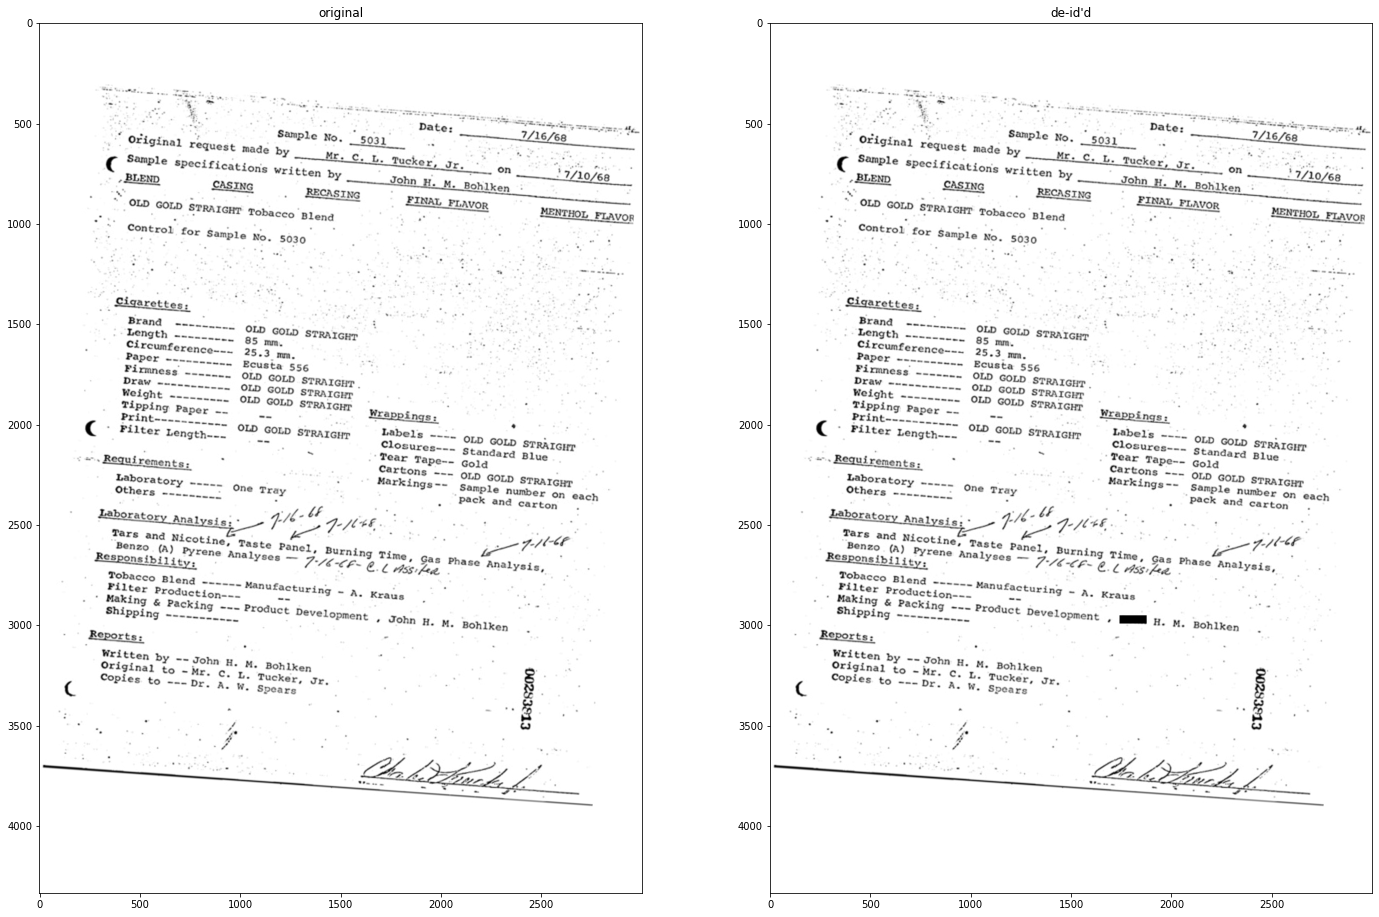

In [0]:
r = deid_result.select("image_raw", "image_with_regions").collect()[3]
img_orig = r.image_raw
img_deid = r.image_with_regions

img_pil_orig = to_pil_image(img_orig, img_orig.mode)
img_pil_deid = to_pil_image(img_deid, img_deid.mode)

plt.figure(figsize=(24,16))
plt.subplot(1, 2, 1)
plt.imshow(img_pil_orig, cmap='gray')
plt.title('original')
plt.subplot(1, 2, 2)
plt.imshow(img_pil_deid, cmap='gray')
plt.title("de-id'd")
plt.show()

## 6. Extracting Text from DICOM images

We have 3 dicom samples and read them from spark-ocr-workshop repo. We will extract text from them. Let's start by reading them.

In [0]:
%sh
for i in {1..3}
do
  wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-ocr-workshop/master/jupyter/data/dicom/deidentify-medical-$i.dcm
done

In [0]:
dicom_df = spark.read.format("binaryFile").load("file:/databricks/driver/deidentify-medical*.dcm")

We can convert Dicom images to image by **`DicomToImage`**.

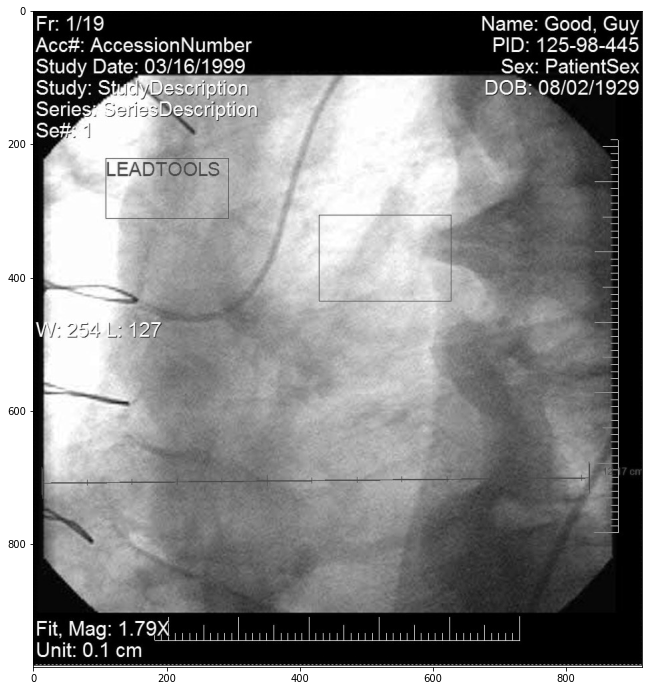

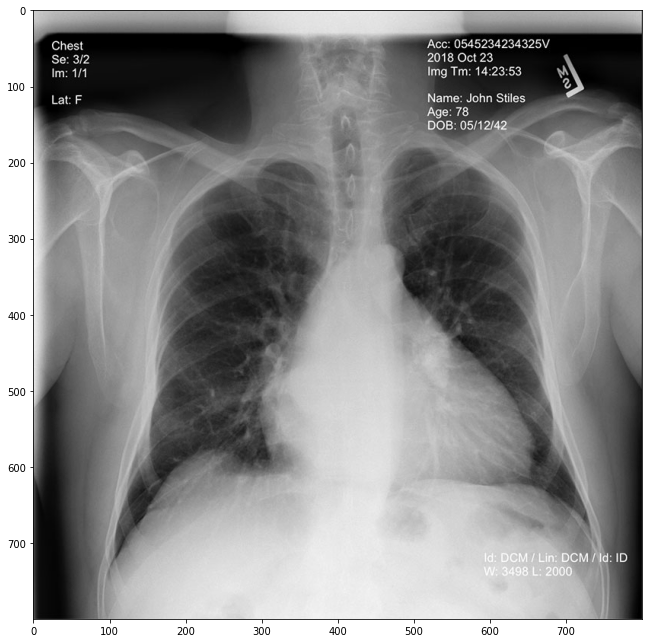

In [0]:
dicomToImage = DicomToImage() \
  .setInputCol("content") \
  .setOutputCol("image") \
  .setMetadataCol("meta")

data = dicomToImage.transform(dicom_df)

for r in data.select("image").collect():
    img = r.image
    img_pil = to_pil_image(img, img.mode)
    plt.figure(figsize=(24,16))
    plt.subplot(1, 2, 1)
    plt.imshow(img_pil, cmap='gray')

And finally, let's extract the text from these images.

In [0]:
# Extract text from image
ocr = ImageToText() \
    .setInputCol("image") \
    .setOutputCol("text") \
    .setIgnoreResolution(False) \
    .setOcrParams(["preserve_interword_spaces=0"])


print("\n".join([row.text for row in ocr.transform(data).select("text").collect()]))

al oat TRS) Name: Good, Guy
(Nee: se Xe) ola elgg o]-18 PID: 125-98-445

Study Date: ore al 999 Sex: PatientSex
_ DOB:,08/02/1929

One)

 

LEADTOOLS

 

 

 

 

 

 

OA yer

2018 Oct 23

Img Tm: 14:23:53
%

Name: John Stiles

## 7. Dicom Image Deidentifier

In [0]:
dicom_to_image = DicomToImage() \
    .setInputCol("content") \
    .setOutputCol("image_raw") \
    .setMetadataCol("metadata") \
    .setDeIdentifyMetadata(True)

ocr = ImageToText() \
    .setInputCol("image_raw") \
    .setOutputCol("text") \
    .setIgnoreResolution(False) \
    .setOcrParams(["preserve_interword_spaces=0"])

# Found coordinates of sensitive data
position_finder = PositionFinder() \
    .setInputCols("ner_chunk") \
    .setOutputCol("coordinates") \
    .setPageMatrixCol("positions") \
    .setMatchingWindow(1000) \
    .setPadding(1)

# Draw filled rectangle for hide sensitive data
drawRegions = ImageDrawRegions()  \
    .setInputCol("image_raw")  \
    .setInputRegionsCol("coordinates")  \
    .setOutputCol("image_with_regions")  \
    .setFilledRect(True) \
    .setRectColor(Color.black)\
    .setLineWidth(10)

# Store image back to Dicom document
imageToDicom = ImageToDicom() \
    .setInputCol("image_with_regions") \
    .setOutputCol("dicom") 


pipeline = Pipeline(stages=[
    dicom_to_image,
    ocr,
    deidentification_nlp_pipeline(input_column="text"),
    position_finder,
    drawRegions,
    imageToDicom
])

embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[ | ][OK!]
ner_deid_large download started this may take some time.
Approximate size to download 14.1 MB
[ | ][OK!]

In [0]:
deid_dicom_df = pipeline.fit(dicom_df).transform(dicom_df).cache()

In [0]:
deid_dicom_df.show(truncate=70)

+------------------------------------------------+----------------------------------------------------------------------+---------+
 path| dicom|exception|
+------------------------------------------------+----------------------------------------------------------------------+---------+
file:/databricks/driver/deidentify-medical-2.dcm|[02 00 01 00 4F 42 00 00 02 00 00 00 00 01 02 00 02 00 55 49 2C 00 ...| |
file:/databricks/driver/deidentify-medical-1.dcm|[02 00 01 00 4F 42 00 00 02 00 00 00 00 01 02 00 02 00 55 49 2C 00 ...| |
+------------------------------------------------+----------------------------------------------------------------------+---------+

In [0]:
for r in deid_dicom_df.select("dicom", "path").collect():
    path, name = os.path.split(r.path)
    filename_split = os.path.splitext(name)
    file_name = os.path.join("/dbfs/", filename_split[0]+".dcm")
    print(f"Storing to {file_name}")
    with open(file_name, "wb") as file:
        file.write(r.dicom)

Storing to /dbfs/deidentify-medical-2.dcm
Storing to /dbfs/deidentify-medical-1.dcm

** Display Deidentified Image and Deidentified metadata**

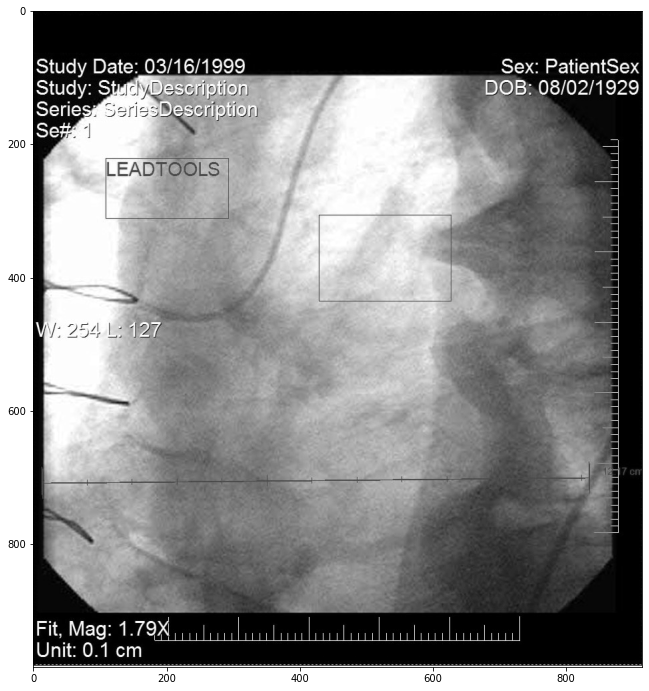

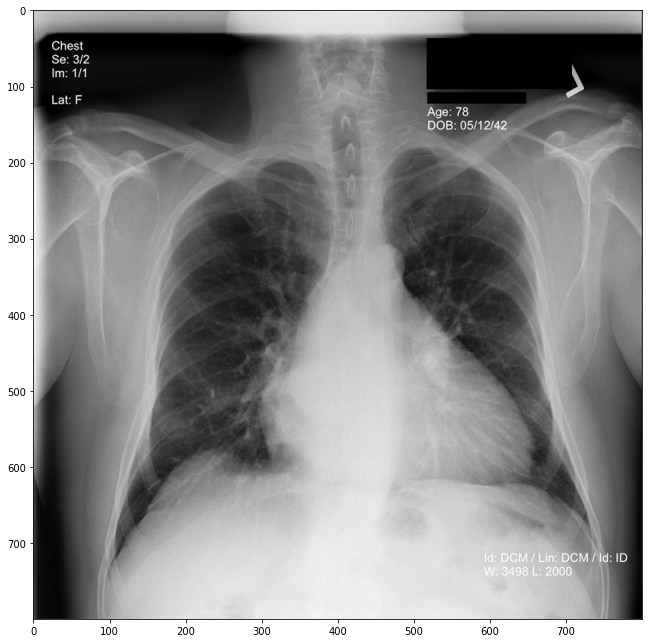

In [0]:
dicom_gen_df = spark.read.format("binaryFile").load("file:/dbfs/*1.dcm")
de_dicom_gen_df = DicomToImage().transform(dicom_gen_df)
for r in de_dicom_gen_df.select("image").collect():
    img = r.image
    img_pil = to_pil_image(img, img.mode)
    plt.figure(figsize=(24,16))
    plt.subplot(1, 2, 1)
    plt.imshow(img_pil, cmap='gray')